In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgbm
import xgboost as xgb

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import roc_auc_score, classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN 

%matplotlib inline

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [3]:
def my_report(data, items_in_cat_features):

    report_columns = ['Name', 'Data format', 'Unique items', 'Nan', 'Category']
    report = pd.DataFrame(columns = report_columns)

    for feature in data.columns:
        column_type = data[feature].dtype                
        nanitems = data[feature].isnull().sum()
        unique_items = len(data[feature].unique())
        
        line = [feature, column_type, unique_items, nanitems]
        
        if unique_items <= 2:
                line.append('Bool')
        if 2 < unique_items <= items_in_cat_features:
                line.append('Categorical')
        if unique_items > items_in_cat_features:
                line.append('Numerical')        
                
        report.loc[len(report.index)] = line        
        report = report.sort_values(by=['Category', 'Nan'],ascending=False)

    return report.set_index('Category')

In [4]:
def calc_std_feat(x):
    res = (x - x.mean(axis=0)) / x.std(axis=0)
    return res

In [5]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
      
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=0.5)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [6]:
def main_feats(X,y,top):
    keys = X.columns.tolist()
    scores = []
    
    for feature in X.columns:
        roc_auc = roc_auc_score(y, X[feature])
        gini = (2*roc_auc - 1).round(2)
        scores.append(gini)
    
    pd_score = pd.DataFrame(data=scores, index=keys, columns=['Gini'])
    sorted_feat = pd_score.sort_values(by='Gini', ascending=False, key = lambda x: np.abs(x))
    
    return sorted_feat.head(top)

## Загрузка данных

In [7]:
link = '/Users/poseluevalexandr/JupiterNotbook/course_project/course_project_train.csv'
testlink = '/Users/poseluevalexandr/JupiterNotbook/course_project/course_project_test.csv'
df = pd.read_csv(link)
df_test = pd.read_csv(testlink)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [8]:
df.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [9]:
target = df.columns[-1]
features = df.columns[:-1]
dff = df[features]

## Соотношение классов целевой переменной

In [10]:
print('Соотношение классов в %')

(df[target].value_counts()/len(df)*100).round(0)

Соотношение классов в %


0    72.0
1    28.0
Name: Credit Default, dtype: float64

## Заполнение пропущенных данных

In [11]:
with_nan = my_report(data=df, items_in_cat_features=20)
with_nan.loc[with_nan['Nan']>0]

,Name,Data format,Unique items,Nan
Category,,,,
Numerical,Months since last delinquent,float64,90,4081
Numerical,Annual Income,float64,5479,1557
Numerical,Credit Score,float64,269,1557
Categorical,Years in current job,object,12,371
Categorical,Bankruptcies,float64,6,14


В признаке "Months since last delinquent" пропущено больше половины. Если его влияние  на целевое значение низкое, то можно удалить. Но сначала необходимо посмотреть на распределение данных

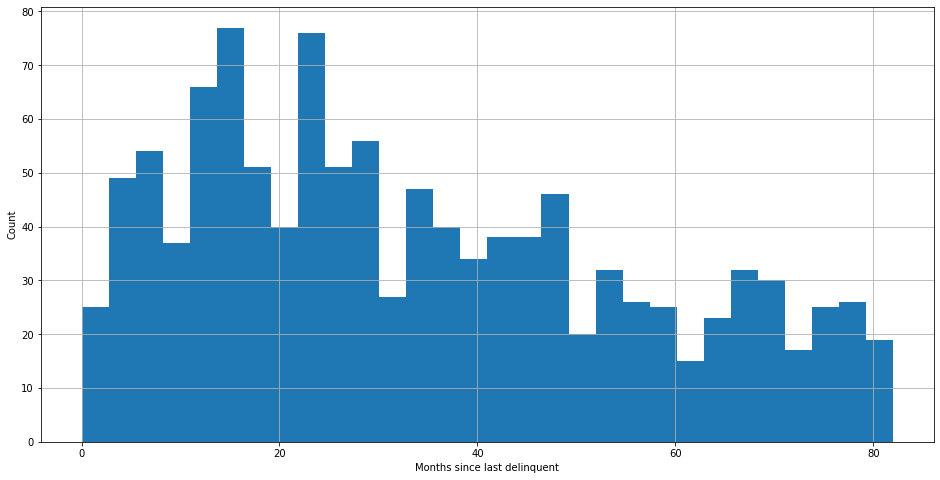

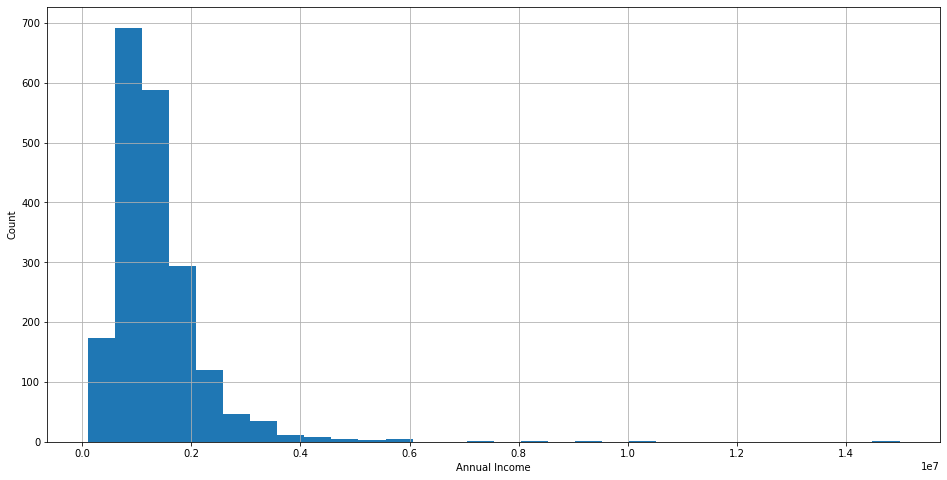

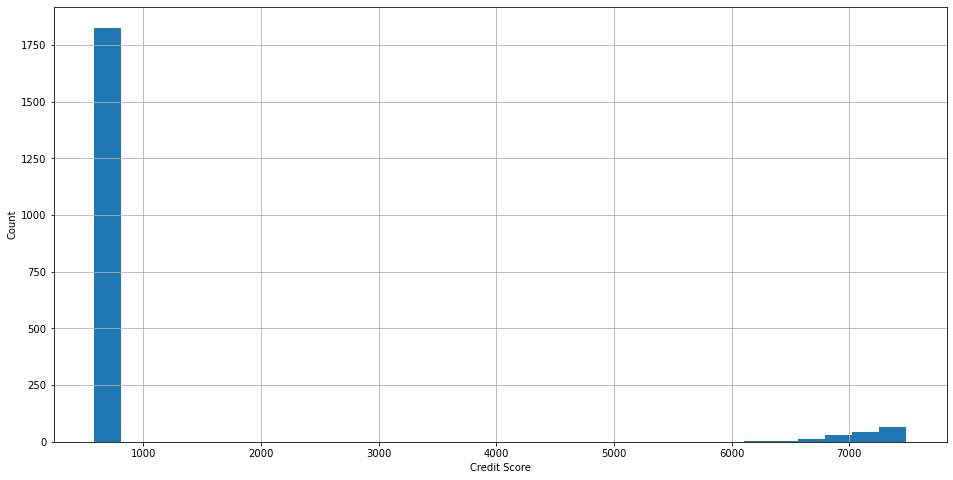

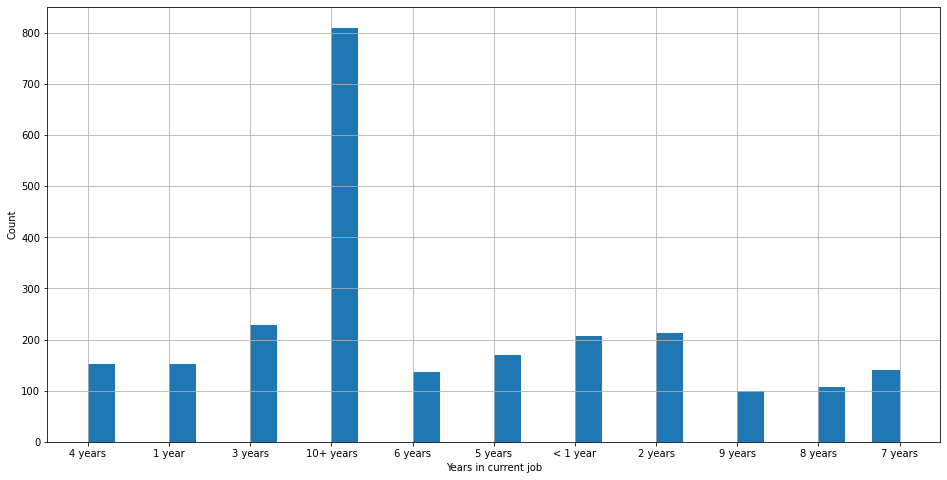

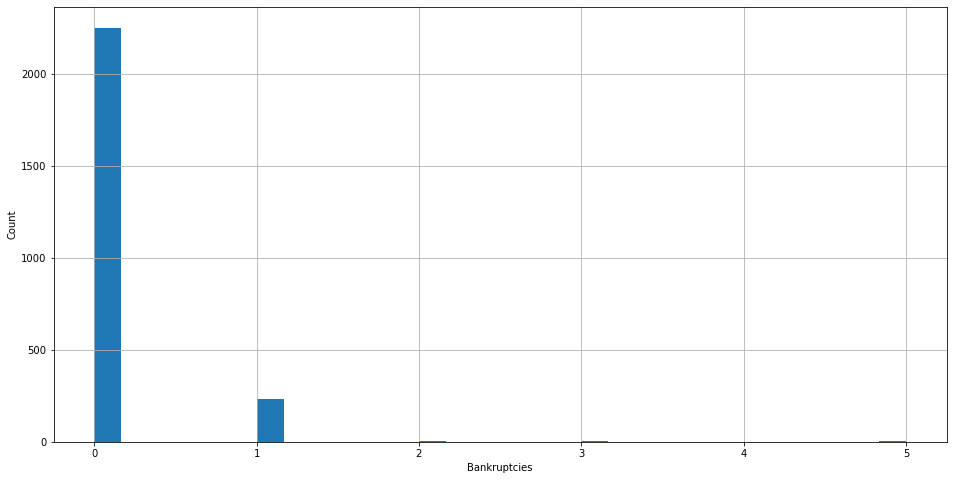

In [12]:
names_list = with_nan.loc[with_nan['Nan']>0, 'Name'].tolist()

for name in names_list:
    plt.figure(figsize = (16, 8))
    df_test[name].hist(bins=30)
    plt.ylabel('Count')
    plt.xlabel(name)
    plt.show()

Теперь заполним пропущенные значения. В нечисловых данных ('Years in current job') - это будут характеристики, которые встречаются чаще других ('10+years')

In [13]:
for name in names_list:
    
    if name == 'Years in current job':
        dff.loc[dff[name].isnull(),
                name] = dff[name].value_counts(normalize=True).index[0]
    else:
        dff.loc[dff[name].isnull(), name] = dff[name].median()


/Users/poseluevalexandr/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


## Подготовка данных

In [14]:
base = my_report(data=dff, items_in_cat_features=20)
base

,Name,Data format,Unique items,Nan
Category,,,,
Numerical,Annual Income,float64,5478,0
Numerical,Number of Open Accounts,float64,39,0
Numerical,Years of Credit History,float64,408,0
Numerical,Maximum Open Credit,float64,6963,0
Numerical,Months since last delinquent,float64,89,0
Numerical,Current Loan Amount,float64,5386,0
Numerical,Current Credit Balance,float64,6592,0
Numerical,Monthly Debt,float64,6716,0
Numerical,Credit Score,float64,268,0


Изменения форматов данных под типы категорий

In [15]:
categores = base.loc[(base.index=='Categorical') & (base['Data format']!= 'object'),
                     'Name'].tolist()
categores

['Tax Liens', 'Number of Credit Problems', 'Bankruptcies']

In [16]:
df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [17]:
dff[categores] = dff[categores].astype(str)
dff = dff.drop('Months since last delinquent', axis=1)
dff['Term'] = (dff['Term'] == 'Short Term').astype(int)
dff = pd.get_dummies(dff)

/Users/poseluevalexandr/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [18]:
len(dff.columns)

60

In [20]:
main_feats(X=dff,y=df[target], top=10)

,Gini
Term,-0.18
Annual Income,-0.12
Current Loan Amount,-0.09
Maximum Open Credit,-0.08
Home Ownership_Home Mortgage,-0.07
Home Ownership_Rent,0.07
Years of Credit History,-0.04
Number of Open Accounts,0.04
Monthly Debt,0.03
Credit Score,0.02


In [21]:
short_feat_list = main_feats(X=dff,y=df[target], top=15).index.tolist()
short_feat_list

['Term',
 'Annual Income',
 'Current Loan Amount',
 'Maximum Open Credit',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Rent',
 'Years of Credit History',
 'Number of Open Accounts',
 'Monthly Debt',
 'Credit Score',
 'Tax Liens_0.0',
 'Purpose_debt consolidation',
 'Home Ownership_Own Home',
 'Years in current job_9 years',
 'Purpose_business loan']

## Обучение и проверка алгоритмов

In [22]:
X = dff
y = df[target]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=100)

### LightGBM

In [23]:
lgbm_model = lgbm.LGBMClassifier(random_state=42,
                                num_leaves=3,
                                max_depth=3,
                                learning_rate=0.1,
                                n_estimators=100,
                                reg_lambda=15,
                                n_jobs=-1)

# Балансирование классов
# ada = ADASYN(random_state=100)
# X_res, y_res = ada.fit_resample(X_train, y_train)


lgbm_model.fit(X_train, y_train)

y_train_pred = lgbm_model.predict(X_train)
y_valid_pred = lgbm_model.predict(X_valid)
y_valid_pred_probs = lgbm_model.predict_proba(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3794
           1       0.97      0.21      0.34      1456

    accuracy                           0.78      5250
   macro avg       0.87      0.60      0.60      5250
weighted avg       0.82      0.78      0.72      5250

TEST

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      1593
           1       0.98      0.19      0.32       657

    accuracy                           0.76      2250
   macro avg       0.86      0.60      0.59      2250
weighted avg       0.82      0.76      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1590    3
1                530  127


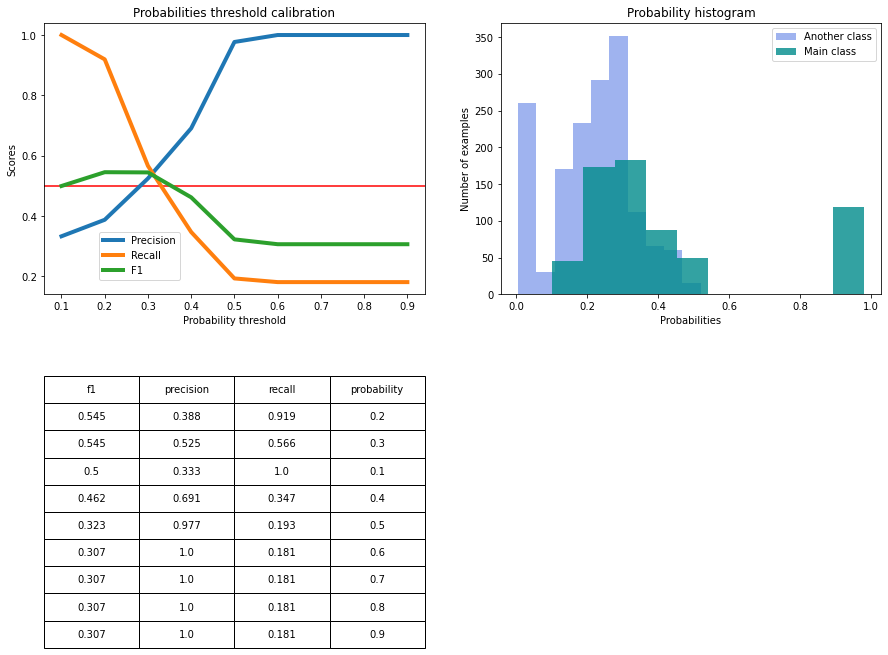

CPU times: user 1.75 s, sys: 409 ms, total: 2.16 s
Wall time: 549 ms


In [24]:
%%time

lgbm_model.fit(X_train, y_train)
y_valid_pred_probs = lgbm_model.predict_proba(X_valid)[:, 1]
show_proba_calibration_plots(y_valid_pred_probs, y_valid)

In [25]:
y_valid_pred = np.where(y_valid_pred_probs > 0.3, 1, 0)
#y_valid_pred = np.array(y_valid_pred_probs > 0.30, dtype=int)[:,1]
y_valid_pred

array([0, 1, 0, ..., 0, 0, 1])

In [26]:
get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3794
           1       0.97      0.21      0.34      1456

    accuracy                           0.78      5250
   macro avg       0.87      0.60      0.60      5250
weighted avg       0.82      0.78      0.72      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1593
           1       0.52      0.57      0.54       657

    accuracy                           0.72      2250
   macro avg       0.67      0.68      0.67      2250
weighted avg       0.73      0.72      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1256  337
1                285  372
